# Forest cover prediction using deep learning
Data from the US Forest Service (USFS) Region 2 Resource Information System.
This study area includes four wilderness areas located in the Roosevelt National Forest of northern Colorado.

It seems to come from Kaggle: https://www.kaggle.com/competitions/cover-type-prediction-of-forests/data

### Import modules
I like to keep my imports together

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical

import numpy as np

import matplotlib.pyplot as plt

import pandas as pd

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score



from matplotlib import pyplot as plt
from collections import Counter


2023-03-07 16:48:49.424113: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-07 16:48:49.545854: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-07 16:48:49.545875: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-07 16:48:50.180176: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

## Import and explore dataset

In [2]:
dataset = pd.read_csv("cover_data.csv")

In [3]:
#Print info on the dataset
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 55 columns):
 #   Column                              Non-Null Count   Dtype
---  ------                              --------------   -----
 0   Elevation                           581012 non-null  int64
 1   Aspect                              581012 non-null  int64
 2   Slope                               581012 non-null  int64
 3   Horizontal_Distance_To_Hydrology    581012 non-null  int64
 4   Vertical_Distance_To_Hydrology      581012 non-null  int64
 5   Horizontal_Distance_To_Roadways     581012 non-null  int64
 6   Hillshade_9am                       581012 non-null  int64
 7   Hillshade_Noon                      581012 non-null  int64
 8   Hillshade_3pm                       581012 non-null  int64
 9   Horizontal_Distance_To_Fire_Points  581012 non-null  int64
 10  Wilderness_Area1                    581012 non-null  int64
 11  Wilderness_Area2                    581012 non-null 

Nice, all data is numeric.  

We want to predict the column "class"  
Let us see some more info

In [4]:
#print the class distribution
print(Counter(dataset["class"]))

Counter({2: 283301, 1: 211840, 3: 35754, 7: 20510, 6: 17367, 5: 9493, 4: 2747})


Note, there are much more entries of 1 and 2 compared to the rest. This is important, as will become clear.

Forest Cover Type Classes (From Kaggle):  
1 -- Spruce/Fir  
2 -- Lodgepole Pine  
3 -- Ponderosa Pine  
4 -- Cottonwood/Willow  
5 -- Aspen  
6 -- Douglas-fir  
7 -- Krummholz

In [5]:
# Lets make a labels dict
labels = {1 : "Spruce/Fir",
          2 : "Lodgepole Pine",
          3 : "Ponderosa Pine",
          4 : "Cottonwood/Willow",
          5 : "Aspen",
          6 : "Douglas-fir",
          7 : "Krummholz"}

## Prepare data

First, select features and target data

In [6]:
x = dataset.iloc[:, :-1] # Features is everything but the last column in first approx
y = dataset.iloc[:, -1] # Target is the last column

Then, perform train test split

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 12)

Scale all input data using a ColumnTransformer

In [8]:
# Create the Transformer
numerical_data = x.select_dtypes(include = ["float64", "int64"])
numerical_columns = numerical_data.columns
ct = ColumnTransformer([("Only numerical columns", StandardScaler(), numerical_columns)], remainder = "passthrough")

# Scale data
x_train = ct.fit_transform(x_train)
x_test = ct.transform(x_test)

For Y we will use Crossentropy from Keras

In [9]:
#encode the labels into integers
le = LabelEncoder()
#convert the integer encoded labels into binary vectors
y_train=le.fit_transform(y_train.astype(str))
y_test=le.transform(y_test.astype(str))
#convert the integer encoded labels into binary vectors
y_train = tf.keras.utils.to_categorical(y_train, dtype = 'int64')
y_test = tf.keras.utils.to_categorical(y_test, dtype = 'int64')

## Model Building

### Model 1: simple

Step 1: Define the model

In [10]:
# Building a simple sequential model
simple_model = Sequential() 
#add the input layer with a shape based on the Features
simple_model.add(layers.InputLayer(input_shape=(x_train.shape[1],)))
#add 2 hidden layers
simple_model.add(layers.Dense(28, activation='relu'))
simple_model.add(layers.Dense(14, activation='relu'))
#add an output layer
simple_model.add(layers.Dense(7, activation='softmax'))
# define optimizer and learning rate
learning_rate = 0.001
opt = opt = tf.keras.optimizers.Adam(learning_rate = learning_rate)
#compile the model, sparse categocical cross entropy, adam optimizer, simple accuracy metrics
simple_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
print(simple_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 28)                1540      
                                                                 
 dense_1 (Dense)             (None, 14)                406       
                                                                 
 dense_2 (Dense)             (None, 7)                 105       
                                                                 
Total params: 2,051
Trainable params: 2,051
Non-trainable params: 0
_________________________________________________________________
None


2023-03-07 16:48:56.706948: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-07 16:48:56.707002: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-07 16:48:56.707035: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (e6d0fb11bc5d): /proc/driver/nvidia/version does not exist
2023-03-07 16:48:56.707460: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Step 2: initial fit

In [11]:
history = simple_model.fit(x_train, y_train, epochs=5, batch_size= 100, verbose=1, validation_split = 0.2)

Epoch 1/5
3487/3487 [==============================] - 14s 4ms/step - loss: 0.6602 - accuracy: 0.7241 - val_loss: 0.5892 - val_accuracy: 0.7446
Epoch 2/5
3487/3487 [==============================] - 13s 4ms/step - loss: 0.5671 - accuracy: 0.7564 - val_loss: 0.5538 - val_accuracy: 0.7628
Epoch 3/5
3487/3487 [==============================] - 13s 4ms/step - loss: 0.5408 - accuracy: 0.7683 - val_loss: 0.5371 - val_accuracy: 0.7671
Epoch 4/5
3487/3487 [==============================] - 13s 4ms/step - loss: 0.5226 - accuracy: 0.7759 - val_loss: 0.5191 - val_accuracy: 0.7782
Epoch 5/5
3487/3487 [==============================] - 14s 4ms/step - loss: 0.5086 - accuracy: 0.7826 - val_loss: 0.5051 - val_accuracy: 0.7837


Step 3: plot some results

Final training accuracy: 0.7825660705566406
Final validation accuracy: 0.7837456464767456


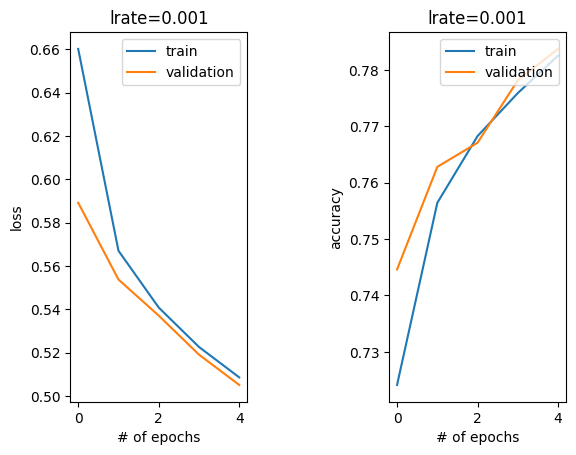

In [12]:
def plot(history):
    # plot learning curves
    fig, axs = plt.subplots(1, 2, gridspec_kw={'hspace': 1, 'wspace': 0.8})
    (ax1, ax2) = axs
    ax1.plot(history.history['loss'], label='train')
    ax1.plot(history.history['val_loss'], label='validation')
    ax1.set_title('lrate=' + str(learning_rate))
    ax1.legend(loc="upper right")
    ax1.set_xlabel("# of epochs")
    ax1.set_ylabel("loss")

    ax2.plot(history.history['accuracy'], label='train')
    ax2.plot(history.history['val_accuracy'], label='validation')
    ax2.set_title('lrate=' + str(learning_rate))
    ax2.legend(loc="upper right")
    ax2.set_xlabel("# of epochs")
    ax2.set_ylabel("accuracy")
    print("Final training accuracy:", history.history['accuracy'][-1])
    print("Final validation accuracy:", history.history['val_accuracy'][-1])
    plt.show()

plot(history)

Step 4: Save model for later comparison

In [13]:
simple_model_file = "../models/simple_model"
simple_model.save(simple_model_file)

INFO:tensorflow:Assets written to: ../models/simple_model/assets


INFO:tensorflow:Assets written to: ../models/simple_model/assets


In [12]:
simple_model_file = "../models/simple_model"
simple_model = tf.keras.models.load_model(simple_model_file)

### Evaluating simple model  
The accuracy looks good, right?

4540/4540 [==============================] - 8s 2ms/step
              precision    recall  f1-score   support

           0       0.80      0.76      0.78     53065
           1       0.80      0.86      0.83     70651
           2       0.71      0.85      0.77      8991
           3       0.67      0.51      0.58       710
           4       0.71      0.18      0.29      2348
           5       0.59      0.32      0.42      4329
           6       0.85      0.71      0.77      5159

    accuracy                           0.79    145253
   macro avg       0.73      0.60      0.63    145253
weighted avg       0.79      0.79      0.78    145253



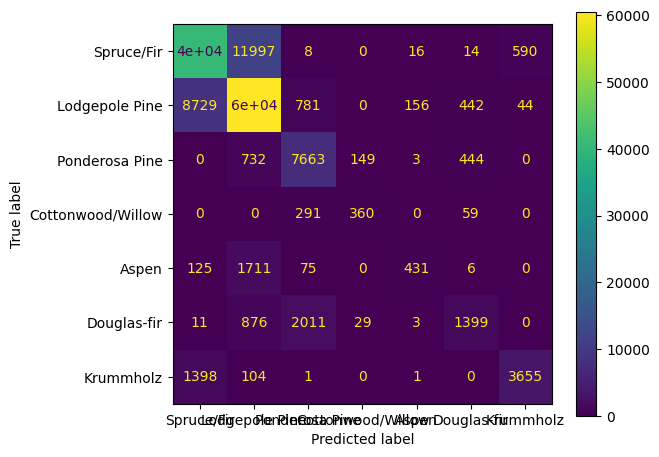

In [16]:
# Calculate some simple metrics and the confusion Matrix
y_pred = simple_model.predict(x_test)
y_pred = np.argmax(y_pred, axis = 1)
print(classification_report(np.argmax(y_test, axis = 1), y_pred))
cm = confusion_matrix(np.argmax(y_test, axis = 1), y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = list(labels.values()))
disp.plot()
plt.tight_layout()
plt.show()

So what we see here is that accuracy is a flawed metric for such an imbalanced dataset.  
The machine learning model clearly favours putting the data in the classes with many samples, as this is "right in most of the cases."
This kind of bias will not get much better with a bit of optimization. Better to:
- Find a way to make the data a bit more balanced by augmenting underrepresented classes/dropping some of the larger ones
- Optimize the metrics with which we score/put some additional weight on the small classes

In [31]:
train_weights = 1/(np.sum(y_train, axis = 0)/np.sum(y_train))
class_weights = {}
for i in range(y_train.shape[1]):
    class_weights[i] = train_weights[i]

In [17]:
# Building a simple sequential model
simple_model2 = Sequential() 
#add the input layer with a shape based on the Features
simple_model2.add(layers.InputLayer(input_shape=(x_train.shape[1],)))
#add 2 hidden layers
simple_model2.add(layers.Dense(28, activation='relu'))
simple_model2.add(layers.Dense(14, activation='relu'))
#add an output layer
simple_model2.add(layers.Dense(7, activation='softmax'))
# define optimizer and learning rate
learning_rate2 = 0.002
opt2 = tf.keras.optimizers.Adam(learning_rate = learning_rate2)
#compile the model, sparse categocical cross entropy, adam optimizer, simple accuracy metrics
simple_model2.compile(loss='categorical_crossentropy', optimizer=opt2, metrics = ["Precision", "Recall"])
print(simple_model2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 28)                1540      
                                                                 
 dense_4 (Dense)             (None, 14)                406       
                                                                 
 dense_5 (Dense)             (None, 7)                 105       
                                                                 
Total params: 2,051
Trainable params: 2,051
Non-trainable params: 0
_________________________________________________________________
None


In [32]:
history2 = simple_model2.fit(x_train, y_train, epochs=5, batch_size= 100, verbose=1, validation_split = 0.2, class_weight = class_weights)

Epoch 1/5
3487/3487 [==============================] - 15s 4ms/step - loss: 3.9774 - precision: 0.7088 - recall: 0.6589 - val_loss: 0.6921 - val_precision: 0.7146 - val_recall: 0.6647
Epoch 2/5
3487/3487 [==============================] - 15s 4ms/step - loss: 3.7272 - precision: 0.7166 - recall: 0.6729 - val_loss: 0.6952 - val_precision: 0.7145 - val_recall: 0.6735
Epoch 3/5
3487/3487 [==============================] - 15s 4ms/step - loss: 3.6198 - precision: 0.7185 - recall: 0.6770 - val_loss: 0.6590 - val_precision: 0.7281 - val_recall: 0.6893
Epoch 4/5
3487/3487 [==============================] - 15s 4ms/step - loss: 3.5420 - precision: 0.7209 - recall: 0.6827 - val_loss: 0.6543 - val_precision: 0.7289 - val_recall: 0.6920
Epoch 5/5
3487/3487 [==============================] - 15s 4ms/step - loss: 3.4787 - precision: 0.7238 - recall: 0.6859 - val_loss: 0.6775 - val_precision: 0.7192 - val_recall: 0.6851


4540/4540 [==============================] - 8s 2ms/step
              precision    recall  f1-score   support

           0       0.75      0.77      0.76     53065
           1       0.85      0.64      0.73     70651
           2       0.75      0.55      0.63      8991
           3       0.47      0.85      0.61       710
           4       0.19      0.90      0.31      2348
           5       0.37      0.87      0.52      4329
           6       0.60      0.95      0.74      5159

    accuracy                           0.71    145253
   macro avg       0.57      0.79      0.61    145253
weighted avg       0.77      0.71      0.72    145253



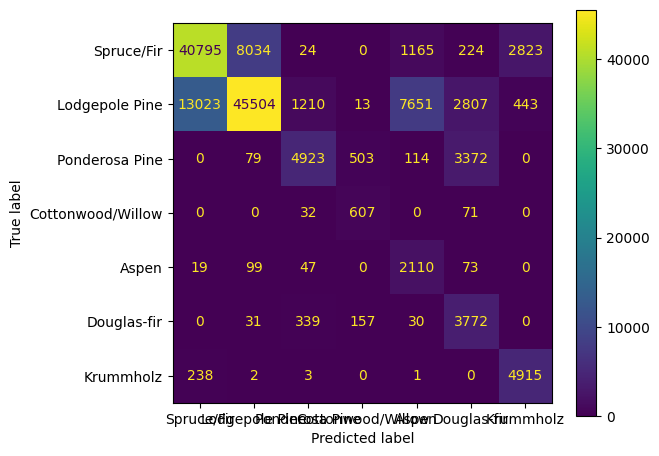

In [33]:
# Calculate some simple metrics and the confusion Matrix
y_pred2 = simple_model2.predict(x_test)
y_pred2 = np.argmax(y_pred2, axis = 1)
print(classification_report(np.argmax(y_test, axis = 1), y_pred2))
cm2 = confusion_matrix(np.argmax(y_test, axis = 1), y_pred2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels = list(labels.values()))
disp.plot()
plt.tight_layout()
plt.show()

Good, although overall score is down, the accuracy for underrepresented classes is up.